# An Example Pipeline using albumentations

## tf.ds with map(albumentation())

In [1]:
# 2021-02-03

In [2]:
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# plt.style.use("bmh")

import cv2
import tensorflow as tf

from datetime import datetime
import seaborn as sns

import errno

# albumentations
from functools import partial
# from albumentations import (
#     Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
#     Rotate
# )
import albumentations as A

# from adabelief_tf import AdaBeliefOptimizer

In [3]:
print(tf.__version__)
print(cv2.__version__)
print(A.__version__)

2.3.1
4.3.0
0.5.2


### 2. Parameters

#### Image size, Batch size, toe/heel-offset.

In [4]:
BATCH_SIZE = 64 # 16 #32 #64 #128 #32 #64 #todo: reduce the BS maybe help to reduce the loss
img_height = 120 #512 #224 #100
img_width = 120 #512 #224 #100

y_offset_toe = 80
y_offset_heel = 280 #400-120=280

#### tf MirroredStrategy seting

In [5]:

# tf MirroredStrategy seting
strategy = tf.distribute.MirroredStrategy()
REPLICAS = strategy.num_replicas_in_sync
print('\nNumber of REPLICAS: {}\n'.format(REPLICAS))


MULTI_BATCH_SIZE = BATCH_SIZE * strategy.num_replicas_in_sync
print('BATCH_SIZE: {}, MULTI_BATCH_SIZE: {}'.format(BATCH_SIZE, MULTI_BATCH_SIZE))



INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)

Number of REPLICAS: 1

BATCH_SIZE: 64, MULTI_BATCH_SIZE: 64


In [6]:
# 自動調節tf.data管道
AUTOTUNE = tf.data.experimental.AUTOTUNE

### 3. Create the training dataset W/ croped


#### Load samples as data-farame

In [7]:

# # data-org #
# ann = 'annotation_1424_merge.csv'
# im_p = 'train/images/'
# df[1335:]


# # data-org-augm#
# ann = 'annotation_2848_augm.csv'
# im_p = 'train_augm/images/'
# df[1335:]


# data-train #
ann = 'annotation_1345_good.csv'
im_p = 'train/images/'

# # data-augm #
# ann = 'annotation_2690_augm.csv'
# im_p = 'train_augm/images/'

# # data-train-HPL-1223
# ann = 'annotation_1123_HPL_Good.csv'
# im_p = 'train/images/'

df = pd.read_csv(ann)
df[1120:]

,images,x1,y1,x2,y2
1120,image_6195.jpg,52,127,75,370
1121,image_6196.jpg,62,138,29,383
1122,image_6197.jpg,54,135,78,380
1123,image_6198.jpg,60,125,29,384
1124,image_6199.jpg,51,147,70,353
...,...,...,...,...,...
1340,image_6419.jpg,60,135,70,381
1341,image_6421.jpg,53,157,76,376
1342,image_6422.jpg,49,154,33,375
1343,image_6423.jpg,64,149,76,381


In [8]:
len(df)

1345

#### Shuffle and reset index

In [9]:
# reset index
df = df.sample(frac=1).reset_index(drop=True)

In [10]:
df.head(10)

,images,x1,y1,x2,y2
0,image_0579.jpg,46,152,36,366
1,image_0314.png,60,141,26,371
2,image_0437.png,54,113,72,362
3,image_0052.png,54,140,36,368
4,image_0156.png,58,143,35,381
5,image_0125.png,53,151,90,382
6,image_0880.png,47,121,80,384
7,image_0343.png,76,157,78,379
8,image_6108.png,60,155,20,385
9,image_0666.png,61,144,77,382


See, the image_####.jpg now are random.

#### Create tf.dataset (DS)

In [11]:
# from dataframe
list_ds = tf.data.Dataset.from_tensor_slices((df['images'], df['x1'], df['y1'], df['x2'], df['y2']))
# list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle

In [12]:
len(list_ds)#.shape() #take(1)

1345

In [13]:
# check The type specification of an element of this dataset.
list_ds.element_spec


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [14]:
# for f,xy1,xy2 in list_ds.take(5):
#     print(f'take sample: {f} {xy1} {xy2}')
#     print(f'{type(xy1)}')
# #     print(f'take sample: {f} {xy1[1]} {xy2[1]}')

In [15]:
for f,x1,y1,x2,y2 in list_ds.take(5):
    print(f'take sample: {f} {x1} {y1} {x2} {y2}')

take sample: b'image_0579.jpg' 46 152 36 366
take sample: b'image_0314.png' 60 141 26 371
take sample: b'image_0437.png' 54 113 72 362
take sample: b'image_0052.png' 54 140 36 368
take sample: b'image_0156.png' 58 143 35 381


In [16]:
# use np decode to UTF-8
print(f.numpy().decode('UTF-8'))

image_0156.png


In [17]:
len(list_ds)

1345

#### Check ds iterator for consuming

In [18]:
# create a Python iterator

it_list_ds = iter(list_ds) # Make sure iter ds only once.

In [19]:
# using iter and consuming its elements using next: every print different image name.

for i in range(4):
    image, x1, y1, x2, y2 = next(it_list_ds)
    print(image.numpy(), x1.numpy(), y1.numpy())

b'image_0579.jpg' 46 152
b'image_0314.png' 60 141
b'image_0437.png' 54 113
b'image_0052.png' 54 140


In [20]:
# image_batch, label_batch = valid_ds_pre_s.as_numpy_iterator().next()
# pred = model.predict_on_batch(image_batch)


for i in range(4):
    image, x1, y1, x2, y2 = list_ds.as_numpy_iterator().next()# every time create a new iter, so need put iter out of above cell.
    print(image, x1, y1, x2, y2)
    
iter_test_list = list_ds.as_numpy_iterator()
print("===== Create iterator once and pull out to above cell. =====")
for i in range(4):
    image, x1, y1, x2, y2 = iter_test_list.next()
    print(image, x1, y1, x2, y2)


b'image_0579.jpg' 46 152 36 366
b'image_0579.jpg' 46 152 36 366
b'image_0579.jpg' 46 152 36 366
b'image_0579.jpg' 46 152 36 366
===== Create iterator once and pull out to above cell. =====
b'image_0579.jpg' 46 152 36 366
b'image_0314.png' 60 141 26 371
b'image_0437.png' 54 113 72 362
b'image_0052.png' 54 140 36 368


#### Process path to image tensor in DS

In [21]:
# # Orignal DS ##
'''
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    # The second to last is the class-directory
    boolen = parts[-2] == class_names
    #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
    one_hot_num = tf.dtypes.cast(boolen, tf.int64)
    one_num = tf.argmax(one_hot_num)
    print('one_num:', one_num)
    # Integer encode the label
    return one_num

def decode_img(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_jpeg(img, channels=3)
    # resize the image to the desired size
#     return tf.image.resize(img, [img_height, img_width])# augment 已經resize過一次了 但這邊不先做會比較慢
    return tf.cast(tf.image.resize(img, [img_height, img_width]), tf.uint8)# 避免float over at augment
'''

#
# map list to ds, Toe part.
#

def decode_crop_png_toe(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y1=y_offset_toe;    x1=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_toe(file_path,x1,y1,x2,y2):
    file_path = im_p + file_path
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_toe(img)
    return img, [x1,y1-y_offset_toe]#Original [0,120], take sample: [76 52], but albu need [42, 53] for sliceing and tuple.

    #return img, x1, y1-y_offset_toe #Original [0,120] #貌似ed不用改，蛋mse變超大
    #return img, [x1/120,(y1-y_offset_toe)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
    #return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] , no help.

#
# map list to ds, Heel part.
#

def decode_crop_png_heel(img):
    # convert the compressed string to a 3D uint8 tensor
    img = tf.io.decode_png(img, channels=3)
    # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
    y2=y_offset_heel;    x2=0;    h=img_height;    w=img_width # not the pp location
    img = tf.image.crop_to_bounding_box(img, int(y2), int(x2), h, w)
    #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
    # resize the image to the desired size
    return img

def process_path_heel(file_path,x1,y1,x2,y2):
    file_path = im_p + file_path
    #label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    img = decode_crop_png_heel(img)
    return img, [x2,y2-y_offset_heel]#Original [0,120], take sample: [76 52]

    #return img, x2, y2-y_offset_heel #Original [0,120] #貌似ed不用改，蛋mse變超大
    #return img, [x2/120,(y2-y_offset_heel)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
    #return img, [(x2-60)/60,((y2-y_offset_heel)-60)/60]#normalized [-1,1] , no help.

#
# test how to put parameters to map
#

def t_ds_map(file_path,x1,y1,x2,y2):
#     img = get_img('train/images/' + str(file_path))
#     print(file_path)
    return file_path,x1,y1,x2,y2 #img, [x1,y1]
    

In [22]:
tf.random.uniform([], 0, 1.0, dtype=tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=0.62086725>

In [23]:
# # # 手寫xy jitter 在ds.map# #


# #
# # map list to ds, Toe part.
# #

# jitt_range = 10

# def process_path_toe(file_path,x1,y1,x2,y2):
#     file_path = im_p + file_path
#     # load the raw data from the file as a string
#     img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    
#     # XY Jitter #
#     if tf.random.uniform([], 0, 1.0, dtype=tf.float32) > 0.5:
#         jtp = tf.random.uniform([], 1, jitt_range, tf.int64)
#         #jtp = tf.cast(10,  tf.int64)
#     else:
#         jtp = tf.cast(0,  tf.int64)
        
#     if tf.random.uniform([], 0, 1.0, dtype=tf.float32) > 0.5:
#         by1=y_offset_toe+jtp
#         y1=y1-y_offset_toe-jtp
#     else:
#         by1=y_offset_toe-jtp
#         y1=y1-y_offset_toe+jtp
        
#     img = tf.io.decode_png(img, channels=3)    
#     bx1=0;    h=img_height;    w=img_width # not the pp location
#     img = tf.image.crop_to_bounding_box(img, int(by1), int(bx1), h, w)

#     return img, [x1,y1]#Original [0,120], take sample: [76 52]


# #
# # map list to ds, Heel part.
# #

# def process_path_heel(file_path,x1,y1,x2,y2):
#     file_path = im_p + file_path
#     # load the raw data from the file as a string
#     img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
    
#     # XY Jitter #
#     if tf.random.uniform([], 0, 1.0, dtype=tf.float32) > 0.5:
#         jtp = tf.random.uniform([], 1, jitt_range, tf.int64)
#         #jtp = tf.cast(10,  tf.int64)
#     else:
#         jtp = tf.cast(0,  tf.int64)
        
# #     if tf.random.uniform([], 0, 1.0, dtype=tf.float32) > 0.5:
# #         by2=y_offset_heel+jtp
# #         y2=y2-y_offset_heel-jtp
# #     else:
#     by2=y_offset_heel-jtp
#     y2=y2-y_offset_heel+jtp
        
#     img = tf.io.decode_png(img, channels=3)
#     bx2=0;    h=img_height;    w=img_width # not the pp location
#     img = tf.image.crop_to_bounding_box(img, int(by2), int(bx2), h, w)
#     return img, [x2,y2]#Original [0,120], take sample: [76 52]
# # heel是最底端+jtp會超過影像。



In [24]:
# # Test albu

# '''
# def get_label(file_path):
#     # convert the path to a list of path components
#     parts = tf.strings.split(file_path, os.path.sep)
#     # The second to last is the class-directory
#     boolen = parts[-2] == class_names
#     #one_hot_num = np.array(boolen, dtype=np.int) not works should use tf.x repalced.
#     one_hot_num = tf.dtypes.cast(boolen, tf.int64)
#     one_num = tf.argmax(one_hot_num)
#     print('one_num:', one_num)
#     # Integer encode the label
#     return one_num

# def decode_img(img):
#     # convert the compressed string to a 3D uint8 tensor
#     img = tf.io.decode_jpeg(img, channels=3)
#     # resize the image to the desired size
# #     return tf.image.resize(img, [img_height, img_width])# augment 已經resize過一次了 但這邊不先做會比較慢
#     return tf.cast(tf.image.resize(img, [img_height, img_width]), tf.uint8)# 避免float over at augment
# '''

# #
# # map list to ds, Toe part.
# #

# def decode_crop_png_toe(img):
#     # convert the compressed string to a 3D uint8 tensor
#     img = tf.io.decode_png(img, channels=3)
#     # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
#     y1=y_offset_toe;    x1=0;    h=img_height;    w=img_width # not the pp location
#     img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), h, w)
#     #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
#     # resize the image to the desired size
#     return img

# def process_path_toe(file_path,xy1,xy2):
#     file_path = im_p + file_path
#     #label = get_label(file_path)
#     # load the raw data from the file as a string
#     img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
#     img = decode_crop_png_toe(img)
#     xy = xy1[0],xy1[1]-y_offset_toe
#     return img, xy#Original [0,120] # to tupe [(x, y)] for albu
# #take sample: (<tf.Tensor: shape=(), dtype=int64, numpy=76>, <tf.Tensor: shape=(), dtype=int64, numpy=52>)
# # take sample: <class 'tuple'>

# #     return img, [x1,y1-y_offset_toe]#Original [0,120], take sample: [76 52]

#     #return img, x1, y1-y_offset_toe #Original [0,120] #貌似ed不用改，蛋mse變超大
#     #return img, [x1/120,(y1-y_offset_toe)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
#     #return img, [(x1-60)/60,((y1-y_offset_toe)-60)/60]#normalized [-1,1] , no help.

# #
# # map list to ds, Heel part.
# #

# def decode_crop_png_heel(img):
#     # convert the compressed string to a 3D uint8 tensor
#     img = tf.io.decode_png(img, channels=3)
#     # crop the toe from top-left corner [image, offset_height y1, offset_width x1, target_height, target_width]
#     y2=y_offset_heel;    x2=0;    h=img_height;    w=img_width # not the pp location
#     img = tf.image.crop_to_bounding_box(img, int(y2), int(x2), h, w)
#     #img = tf.image.crop_to_bounding_box(img, int(y1), int(x1), int(y2)-int(y1), int(x2)-int(x1))
#     # resize the image to the desired size
#     return img

# def process_path_heel(file_path,xy1,xy2):
#     file_path = im_p + file_path
#     #label = get_label(file_path)
#     # load the raw data from the file as a string
#     img = tf.io.read_file(file_path)#can read the byte string paths b'image_0001.png'
#     img = decode_crop_png_heel(img)
#     xy = xy2[0],xy2[1]-y_offset_heel
#     return img, xy#Original [0,120] # to tupe [(x, y)] for albu
# #     return img, [x2,y2-y_offset_heel]#Original [0,120], take sample: [76 52]

#     #return img, x2, y2-y_offset_heel #Original [0,120] #貌似ed不用改，蛋mse變超大
#     #return img, [x2/120,(y2-y_offset_heel)/120]#normalized [0,1] xy <dtype: 'float64'>, no help.
#     #return img, [(x2-60)/60,((y2-y_offset_heel)-60)/60]#normalized [-1,1] , no help.

# #
# # test how to put parameters to map
# #

# def t_ds_map(file_path,x1,y1,x2,y2):
# #     img = get_img('train/images/' + str(file_path))
# #     print(file_path)
#     return file_path,x1,y1,x2,y2 #img, [x1,y1]
    

In [25]:
# Toe ds
train_ds_map_toe = list_ds.map(process_path_toe, num_parallel_calls=AUTOTUNE)

# Heel ds
train_ds_map_heel = list_ds.map(process_path_heel, num_parallel_calls=AUTOTUNE)

In [26]:
# for img, xy in train_ds_map_toe.take(1):
#     print(f'take sample: {xy}')
    
# print('f', f.dtype)
# print('xy', xy.dtype)

# for img, x, y in train_ds_map_toe.take(1):
#     print(f'take sample: {x} {y}')
    
# print('img', img.dtype)
# print('x', x.dtype)
# x

# for img, x, y in train_ds_map_toe.take(1):
#     print(f'take sample: {x} and {y}')
#     print(f'take sample: {type(x)}')
    
# print('img', img.dtype)
# print('x', x.dtype)


# to tupe [(x, y)] for albu
for img, xy in train_ds_map_toe.take(4):
    print(f'take sample: {xy}')
    print(f'take sample: {type(xy)}')
    #take sample: [[57 43]]
# print('f', f.dtype)
# print('xy', xy.dtype)
# print(img.shape)

take sample: [46 72]
take sample: <class 'tensorflow.python.framework.ops.EagerTensor'>
take sample: [60 61]
take sample: <class 'tensorflow.python.framework.ops.EagerTensor'>
take sample: [54 33]
take sample: <class 'tensorflow.python.framework.ops.EagerTensor'>
take sample: [54 60]
take sample: <class 'tensorflow.python.framework.ops.EagerTensor'>


In [27]:
xy

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([54, 60])>

In [28]:
type(xy)

tensorflow.python.framework.ops.EagerTensor

In [29]:
list(xy)

[<tf.Tensor: shape=(), dtype=int64, numpy=54>,
 <tf.Tensor: shape=(), dtype=int64, numpy=60>]

In [30]:
# for f,x1,y1,x2,y2 in train_ds_map.take(5):
#     print(f'take sample: {f} {x1} {y1} {x2} {y2}')

#### [new] Split train_ds_pre with ratio of validation %

[ToDo 20210201] keep orignal validation in 0.1, but augmenting train_ds in input layer or in the tf.ds.

In [31]:
# split Toe
val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.2)
# val_size = int(tf.data.experimental.cardinality(train_ds_map_toe).numpy() * 0.1)#no help

train_ds_map_toe_s = train_ds_map_toe.skip(val_size)
valid_ds_map_toe_s = train_ds_map_toe.take(val_size)

print(len(train_ds_map_toe))
print(val_size)
print(tf.data.experimental.cardinality(train_ds_map_toe_s).numpy())
print(tf.data.experimental.cardinality(valid_ds_map_toe_s).numpy())

1345
269
1076
269


In [32]:
# split Heel
val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.2)
# val_size = int(tf.data.experimental.cardinality(train_ds_map_heel).numpy() * 0.1)


train_ds_map_heel_s = train_ds_map_heel.skip(val_size)
valid_ds_map_heel_s = train_ds_map_heel.take(val_size)

print(len(train_ds_map_heel))
print(val_size)
print(tf.data.experimental.cardinality(train_ds_map_heel_s).numpy())
print(tf.data.experimental.cardinality(valid_ds_map_heel_s).numpy())

1345
269
1076
269


### Albumentation pipeline

In [33]:
keypoints = [
    (264, 203),
    (86, 88),
    (254, 160),
    (193, 103),
    (65, 341),
]

In [34]:
type(keypoints)

list

In [35]:
np.shape(keypoints)

(5, 2)

In [36]:
"""Check keypoints process01: [<tf.Tensor 'keypoints:0' shape=() dtype=int64>, <tf.Tensor 'keypoints_1:0' shape=() dtype=int64>] 
(2,) 
<class 'list'>
出在tf.ds後xy shape(2,) not the (1, 2) tf.reshape應轉後仍卡在tensor問題

在ds.map 中tensor無法使用A.numpy()

tf.make_ndarray也無法硬轉 AttributeError: 'Tensor' object has no attribute 'tensor_shape' 

https://github.com/tensorflow/tensorflow/issues/28840


Go Around
手寫xy jitter在ds.map讀取image階段中
ds.pre時再加上原本的albu增強


"""

"Check keypoints process01: [<tf.Tensor 'keypoints:0' shape=() dtype=int64>, <tf.Tensor 'keypoints_1:0' shape=() dtype=int64>] \n(2,) \n<class 'list'>\n出在tf.ds後xy shape(2,) not the (1, 2) tf.reshape應轉後仍卡在tensor問題\n\n在ds.map 中tensor無法使用A.numpy()\n\ntf.make_ndarray也無法硬轉 AttributeError: 'Tensor' object has no attribute 'tensor_shape' \n\nhttps://github.com/tensorflow/tensorflow/issues/28840\n\n\nGo Around\n手寫xy jitter在ds.map讀取image階段中\nds.pre時再加上原本的albu增強\n\n\n"

In [83]:
# Instantiate augments
# we can apply as many augments we want and adjust the values accordingly
# here I have chosen the augments and their arguments at random
# transforms = A.Compose([
#             A.Rotate(limit=40),
#             A.RandomBrightness(limit=0.1),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.HorizontalFlip(),
#             ]
# #             , 
# #             keypoint_params=A.KeypointParams(format='xy'),  #currently not works for tf.ds yet.
#             )

# #currently used
# # for NO keypoint augment, but LB:8.9 with ds_1345
# transforms = A.Compose([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA (alpha=0.1, always_apply=False, p=0.5),
#             A.Downscale (scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE (clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
# #             A.GlassBlur(sigma=0.9, max_delta=2, iterations=2, always_apply=False, mode='fast', p=0.5),
# #             A.GaussNoise (var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
# #             A.GaussianBlur (blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.5)
# #             A.HorizontalFlip(),
#     #more
# #             A.Equalize(always_apply=False, mode='cv', by_channels=True, p=0.5),
# ])





# #currently used test A.OneOf([,,,])
# # for NO keypoint augment, but LB:8.9 with ds_1345
# transforms = A.Compose(A.OneOf([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA (alpha=0.1, always_apply=False, p=0.5),
#             A.Downscale (scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE (clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
# #             A.GlassBlur(sigma=0.9, max_delta=2, iterations=2, always_apply=False, mode='fast', p=0.5),
# #             A.GaussNoise (var_limit=(10.0, 50.0), mean=0, always_apply=False, p=0.5),
# #             A.GaussianBlur (blur_limit=(3, 7), sigma_limit=0, always_apply=False, p=0.5)
# #             A.HorizontalFlip(),
# ]),p=0.8)




# Testing keypoints augment
transforms = A.Compose([
#             A.RandomBrightness(limit=0.1, p=0.5),
#             A.JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
#             A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
#             A.RandomContrast(limit=0.2, p=0.5),
#             A.FancyPCA (alpha=0.1, always_apply=False, p=0.5),
#             A.Downscale (scale_min=0.7, scale_max=0.9, interpolation=0, always_apply=False, p=0.5),
#             A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, always_apply=False, p=0.5),
#             A.CLAHE (clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
    
#             A.HorizontalFlip(p=0.5),

#             A.RandomResizedCrop(always_apply=False, height=120, width=120, scale=(0.75, 0.9), ratio=(1.0, 1.0), interpolation=0, p=0.5),#xy become double need change dtype of label. # pp will outside the image.
#             A.IAAAffine (scale=0.9, translate_percent=None, translate_px=None, rotate=0.0, shear=0.0, order=1, cval=0, mode='reflect', always_apply=False, p=0.5),
# #             A.ShiftScaleRotate(always_apply=False, p=0.5, shift_limit=(0.06, 0.06), scale_limit=(-0.1, 0.1), rotate_limit=(-5, 5), interpolation=1, border_mode=2, value=(0, 0, 0), mask_value=None),
#             A.IAAPerspective(scale=(0.02, 0.08), keep_size=True, always_apply=False, p=0.5),#容易造成界外error至訓練中斷
            A.IAASuperpixels(p_replace=0.1, n_segments=5, always_apply=False, p=0.5),# 類似mean shift的大區塊像素
            ], 
            keypoint_params=A.KeypointParams(format='xy',remove_invisible=True),  #currently not works for tf.ds yet.
            )


In [84]:
# # # workable for non keypoint augment
# def aug_fn(image, img_size):
#     data = {"image":image}
#     aug_data = transforms(**data)
#     aug_img = aug_data["image"]
# #     aug_img = tf.cast(aug_img/255.0, tf.float32)
#     aug_img = tf.cast(aug_img, tf.float32)
#     aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
#     return aug_img

# def process_data(image, label, img_size):
#     aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     return aug_img, label


"""
Comparison to tf.py_function: tf.py_function and tf.numpy_function are very similar, except that tf.numpy_function 
takes numpy arrays, and not tf.Tensors. If you want the function to contain tf.Tensors, and have any TensorFlow 
operations executed in the function be differentiable, please use tf.py_function.

"""

# Testing keypoints augment
# @tf.function
def aug_fn(image, keypoints, img_size):
    print('Check keypoints aug_fun 00:', keypoints) # Check keypoints aug_fun 00: [[53 58]]
#     data = {"image":image}
    aug_data = transforms(image=image, keypoints=keypoints)
    aug_img = aug_data["image"]
    aug_xy  = aug_data["keypoints"]
#     aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.cast(aug_img, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    
    aug_xy = tf.cast(aug_xy, tf.float32) #有些變形輸出是double
    print('Check aug_xy:', aug_xy) # Check aug_xy: [(95, 45)] #印到這邊都是對的
    return aug_img, aug_xy 

# @tf.function
def process_data(image, keypoints, img_size):
    
    print('Check keypoints process01:', keypoints, np.shape(keypoints), type(keypoints))
        
#     keypoints = tf.make_ndarray(keypoints)
#     keypoints = np.array(keypoints)
#     keypoints = list(keypoints)
#     keypoints = np.asarray(keypoints, dtype=np.float32)
#     keypoints = tf.make_ndarray(keypoints.op.get_attr('value'))

#     keypoints = tf.reshape(keypoints, [1, 2])
    keypoints = tf.reshape(keypoints, [1, 2]) # for 'convert_keypoint_to_albumentations'
#     keypoints = np.reshape(keypoints, (1, 2))#not support tensor with np.call.

    print('Check keypoints process02:', keypoints, np.shape(keypoints), type(keypoints))

#     aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
#     aug_img, aug_xy = tf.py_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.int64])#for tensors.
    aug_img, aug_xy = tf.numpy_function(func=aug_fn, inp=[image, keypoints, img_size], Tout=[tf.float32, tf.float32])
    print('Check keypoints process03:', aug_xy)
    
    aug_xy = tf.reshape(aug_xy, [2,]) # for 'tf ds tarining'
    print('Check keypoints process04:', aug_xy)
        
    return aug_img, aug_xy 



In [85]:
"""Restoring dataset shapes.
The datasets loses its shape after applying a tf.numpy_function, so this is necessary for the sequential model and when 
inheriting from the model class.
"""

"""
No restoring shape
<PrefetchDataset shapes: (<unknown>, (None, 2)), types: (tf.float32, tf.int64)>

restoring shape
<PrefetchDataset shapes: ((None, 120, 120, 3), (None, 2)), types: (tf.float32, tf.int64)>
"""

def set_shapes(img, label, img_shape=(120,120,3)):
    img.set_shape(img_shape)
#     label.set_shape([]) # commited for go around error
    return img, label

#### prepare train_ds_prefetch

In [86]:
def configure_for_performance_cache_train(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache.
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
#         ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
#         ds = ds.map(AA, num_parallel_calls=AUTOTUNE)
#         ds = ds.map(RA, num_parallel_calls=AUTOTUNE)
#         print("Check augment :Y", augment)

        ds = ds.map(partial(process_data, img_size=120),num_parallel_calls=AUTOTUNE)
        ds = ds.map(set_shapes, num_parallel_calls=AUTOTUNE)
        print("Check augment with albu :Y", augment)

    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
    ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=True) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds

def configure_for_performance_cache_val(ds, cache=True, augment=False):

    
    """#TODO: need to check the parse logic of ds.cache
    TODO:test remove ds.shuffle from val_ds.
    .
    if cache:
        print("Check cache-f1 to file:", cache)
        if isinstance(cache, str):
            ds = ds.cache(cache)
            print("Check cache-f2 to file:", cache)
    else:
        ds = ds.cache()
        print("Check cache in memory:", cache)
    """    
    if cache:
        ds = ds.cache()
        print("Check cache in memory:Y", cache)
    else:
        print("Check cache in memory:N", cache)
        
    if augment:
#         ds = ds.map(data_augment, num_parallel_calls=AUTOTUNE)
        ds = ds.map(AA, num_parallel_calls=AUTOTUNE)
#         ds = ds.map(RA, num_parallel_calls=AUTOTUNE)
        print("Check augment :Y", augment)
    else:
        print("Check augment :N", augment)
    
    #ds = ds.repeat()#TODO:2020-12-14: test
    #ds = ds.shuffle(buffer_size=MULTI_BATCH_SIZE*2) # (buffer_size=MULTI_BATCH_SIZE*5) 6sec,buffer_size=1000 take few sec. or buffer_size=image_count <- take too long # each take ds take 30~45 sec, TODO!!
#     ds = ds.shuffle(len(list_ds), reshuffle_each_iteration=False) #todo: move to ds_pre. see https://www.tensorflow.org/api_docs/python/tf/data/Dataset#shuffle
    ds = ds.batch(MULTI_BATCH_SIZE)#MULTI_BATCH_SIZE for multi-GPUs
    ds = ds.prefetch(buffer_size=AUTOTUNE) #buffer_size=AUTOTUNE seem no speed improve
    
    print("Check ds cache[{}] and augment[{}]".format(cache, augment))
    
    return ds


In [87]:
# """
# Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
# """
# # Toe ds_pre
# train_ds_pre_toe = configure_for_performance_cache_train(train_ds_map_toe)

# # Heel ds_pre
# train_ds_pre_heel = configure_for_performance_cache_val(train_ds_map_heel)

#### All split ds_prefetch
* train_ds_map_toe_s = train_ds_map_toe.skip(val_size)
* valid_ds_map_toe_s = train_ds_map_toe.take(val_size)

* train_ds_map_heel_s = train_ds_map_heel.skip(val_size)
* valid_ds_map_heel_s = train_ds_map_heel.take(val_size)


In [88]:
"""
Prepare the ds properties (cache, augment, bs, shuffle, prefetch, etc.) for better performance.
"""
# Toe ds_pre
train_ds_pre_toe_s = configure_for_performance_cache_train(train_ds_map_toe_s, augment=True)
valid_ds_pre_toe_s = configure_for_performance_cache_val(valid_ds_map_toe_s)

# Heel ds_pre
train_ds_pre_heel_s = configure_for_performance_cache_train(train_ds_map_heel_s, augment=True)
valid_ds_pre_heel_s = configure_for_performance_cache_val(valid_ds_map_heel_s)

Check cache in memory:Y True
Check keypoints process01: Tensor("args_1:0", shape=(2,), dtype=int64) (2,) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process02: Tensor("Reshape:0", shape=(1, 2), dtype=int64) (1, 2) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process03: Tensor("PyFunc:1", dtype=float32, device=/job:localhost/replica:0/task:0)
Check keypoints process04: Tensor("Reshape_1:0", shape=(2,), dtype=float32)
Check augment with albu :Y True
Check ds cache[True] and augment[True]
Check cache in memory:Y True
Check augment :N False
Check ds cache[True] and augment[False]
Check cache in memory:Y True
Check keypoints process01: Tensor("args_1:0", shape=(2,), dtype=int64) (2,) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process02: Tensor("Reshape:0", shape=(1, 2), dtype=int64) (1, 2) <class 'tensorflow.python.framework.ops.Tensor'>
Check keypoints process03: Tensor("PyFunc:1", dtype=float32, device=/job:localhost/replica:0

In [89]:
"""
No restoring shape
<PrefetchDataset shapes: (<unknown>, (None, 2)), types: (tf.float32, tf.int64)>

restoring shape
<PrefetchDataset shapes: ((None, 120, 120, 3), (None, 2)), types: (tf.float32, tf.int64)>
"""
train_ds_pre_toe_s

<PrefetchDataset shapes: ((None, 120, 120, 3), (None, 2)), types: (tf.float32, tf.float32)>

In [90]:
train_ds_pre_heel_s

<PrefetchDataset shapes: ((None, 120, 120, 3), (None, 2)), types: (tf.float32, tf.float32)>

## Check ds_prefetch samples

In [91]:
# create it_ds once
it_train_ds_pre_toe_s = iter(train_ds_pre_toe_s)

Check keypoints aug_fun 00:Check keypoints aug_fun 00: [[62 59]]
 Check keypoints aug_fun 00: [[56 75]]
[[58 68]]
Check aug_xy: Check aug_xy:tf.Tensor([[62. 59.]], shape=(1, 2), dtype=float32)
Check aug_xy: tf.Tensor([[58. 68.]], shape=(1, 2), dtype=float32)Check keypoints aug_fun 00: [[67 33]]

 Check keypoints aug_fun 00:tf.Tensor([[56. 75.]], shape=(1, 2), dtype=float32) [[59 65]]

Check aug_xy: Check keypoints aug_fun 00: [[63 40]]
Check aug_xy: tf.Tensor([[67. 33.]], shape=(1, 2), dtype=float32)tf.Tensor([[59. 65.]], shape=(1, 2), dtype=float32)
Check aug_xy:
Check keypoints aug_fun 00: [[69 55]]
 Check keypoints aug_fun 00:tf.Tensor([[63. 40.]], shape=(1, 2), dtype=float32) 
[[55 56]]
Check keypoints aug_fun 00: [[58 28]]
Check keypoints aug_fun 00: [[57 30]]
Check aug_xy: tf.Tensor([[58. 28.]], shape=(1, 2), dtype=float32)Check aug_xy:
 tf.Tensor([[55. 56.]], shape=(1, 2), dtype=float32)Check aug_xy:
 tf.Tensor([[57. 30.]], shape=(1, 2), dtype=float32)
Check aug_xy: tf.Tensor([[

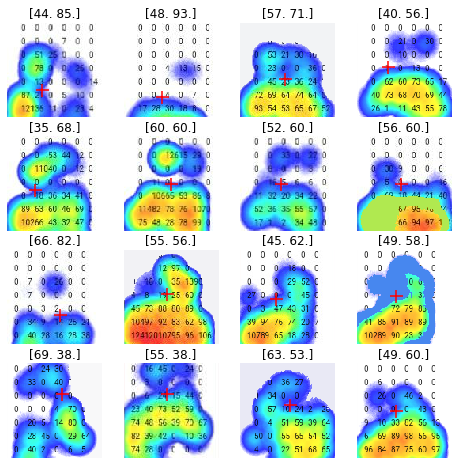

In [92]:
%%time

# for albu keypoint

# for original return aug_img, , aug_xy 


image_batch, label_batch = next(it_train_ds_pre_toe_s)

fig = plt.figure(figsize=(8, 8))
print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(label_batch[i].numpy())
    plt.axis("off")

    plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=1.5)

    print(f'Check lables: {label_batch[i]}')


In [93]:
# create it_ds once
it_train_ds_pre_heel_s = iter(train_ds_pre_heel_s)

batch * multi: 64 , MULTI_BATCH_SIZE= 64
Check lables: [76. 82.]
Check lables: [82. 96.]
Check lables: [ 79. 103.]
Check lables: [ 86. 103.]
Check lables: [ 73. 101.]
Check lables: [67. 88.]
Check lables: [ 80. 101.]
Check lables: [69. 98.]
Check lables: [ 33. 102.]
Check lables: [ 30. 105.]
Check lables: [ 25. 100.]
Check lables: [ 82. 104.]
Check lables: [29. 99.]
Check lables: [ 82. 106.]
Check lables: [85. 99.]
Check lables: [ 81. 102.]
CPU times: user 170 ms, sys: 14 ms, total: 184 ms
Wall time: 168 ms


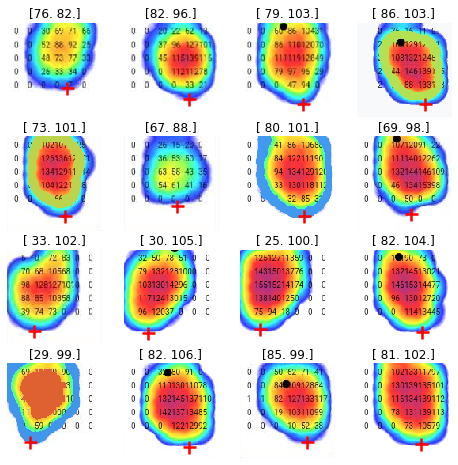

In [99]:
%%time

# for albu keypoint

# for original return aug_img, , aug_xy 


image_batch, label_batch = next(it_train_ds_pre_heel_s)

fig = plt.figure(figsize=(8, 8))
print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
for i in range(16):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(label_batch[i].numpy())
    plt.axis("off")

    plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=13, mew=2.5)

    print(f'Check lables: {label_batch[i]}')

In [95]:
# create it_ds once
it_valid_ds_pre_toe_s = iter(valid_ds_pre_toe_s)

batch * multi: 64 , MULTI_BATCH_SIZE= 64
Check lables: [46 72]
Check lables: [60 61]
Check lables: [54 33]
Check lables: [54 60]
Check lables: [58 63]
Check lables: [53 71]
Check lables: [47 41]
Check lables: [76 77]
Check lables: [60 75]
Check lables: [61 64]
Check lables: [57 56]
Check lables: [57 73]
Check lables: [52 59]
Check lables: [60 56]
Check lables: [55 57]
Check lables: [60 49]
Check lables: [51 36]
Check lables: [44 38]
Check lables: [63 70]
Check lables: [73 44]
Check lables: [59 45]
Check lables: [56 61]
Check lables: [55 59]
Check lables: [64 28]
Check lables: [57 26]
Check lables: [54 62]
Check lables: [62 48]
Check lables: [60 52]
Check lables: [56 29]
Check lables: [51 50]
Check lables: [55 52]
Check lables: [47 57]
Check lables: [54 56]
Check lables: [60 54]
Check lables: [63 46]
Check lables: [48 64]
Check lables: [59 30]
Check lables: [56 70]
Check lables: [58 60]
Check lables: [45 38]
Check lables: [60 60]
Check lables: [66 27]
Check lables: [57 56]
Check lables:

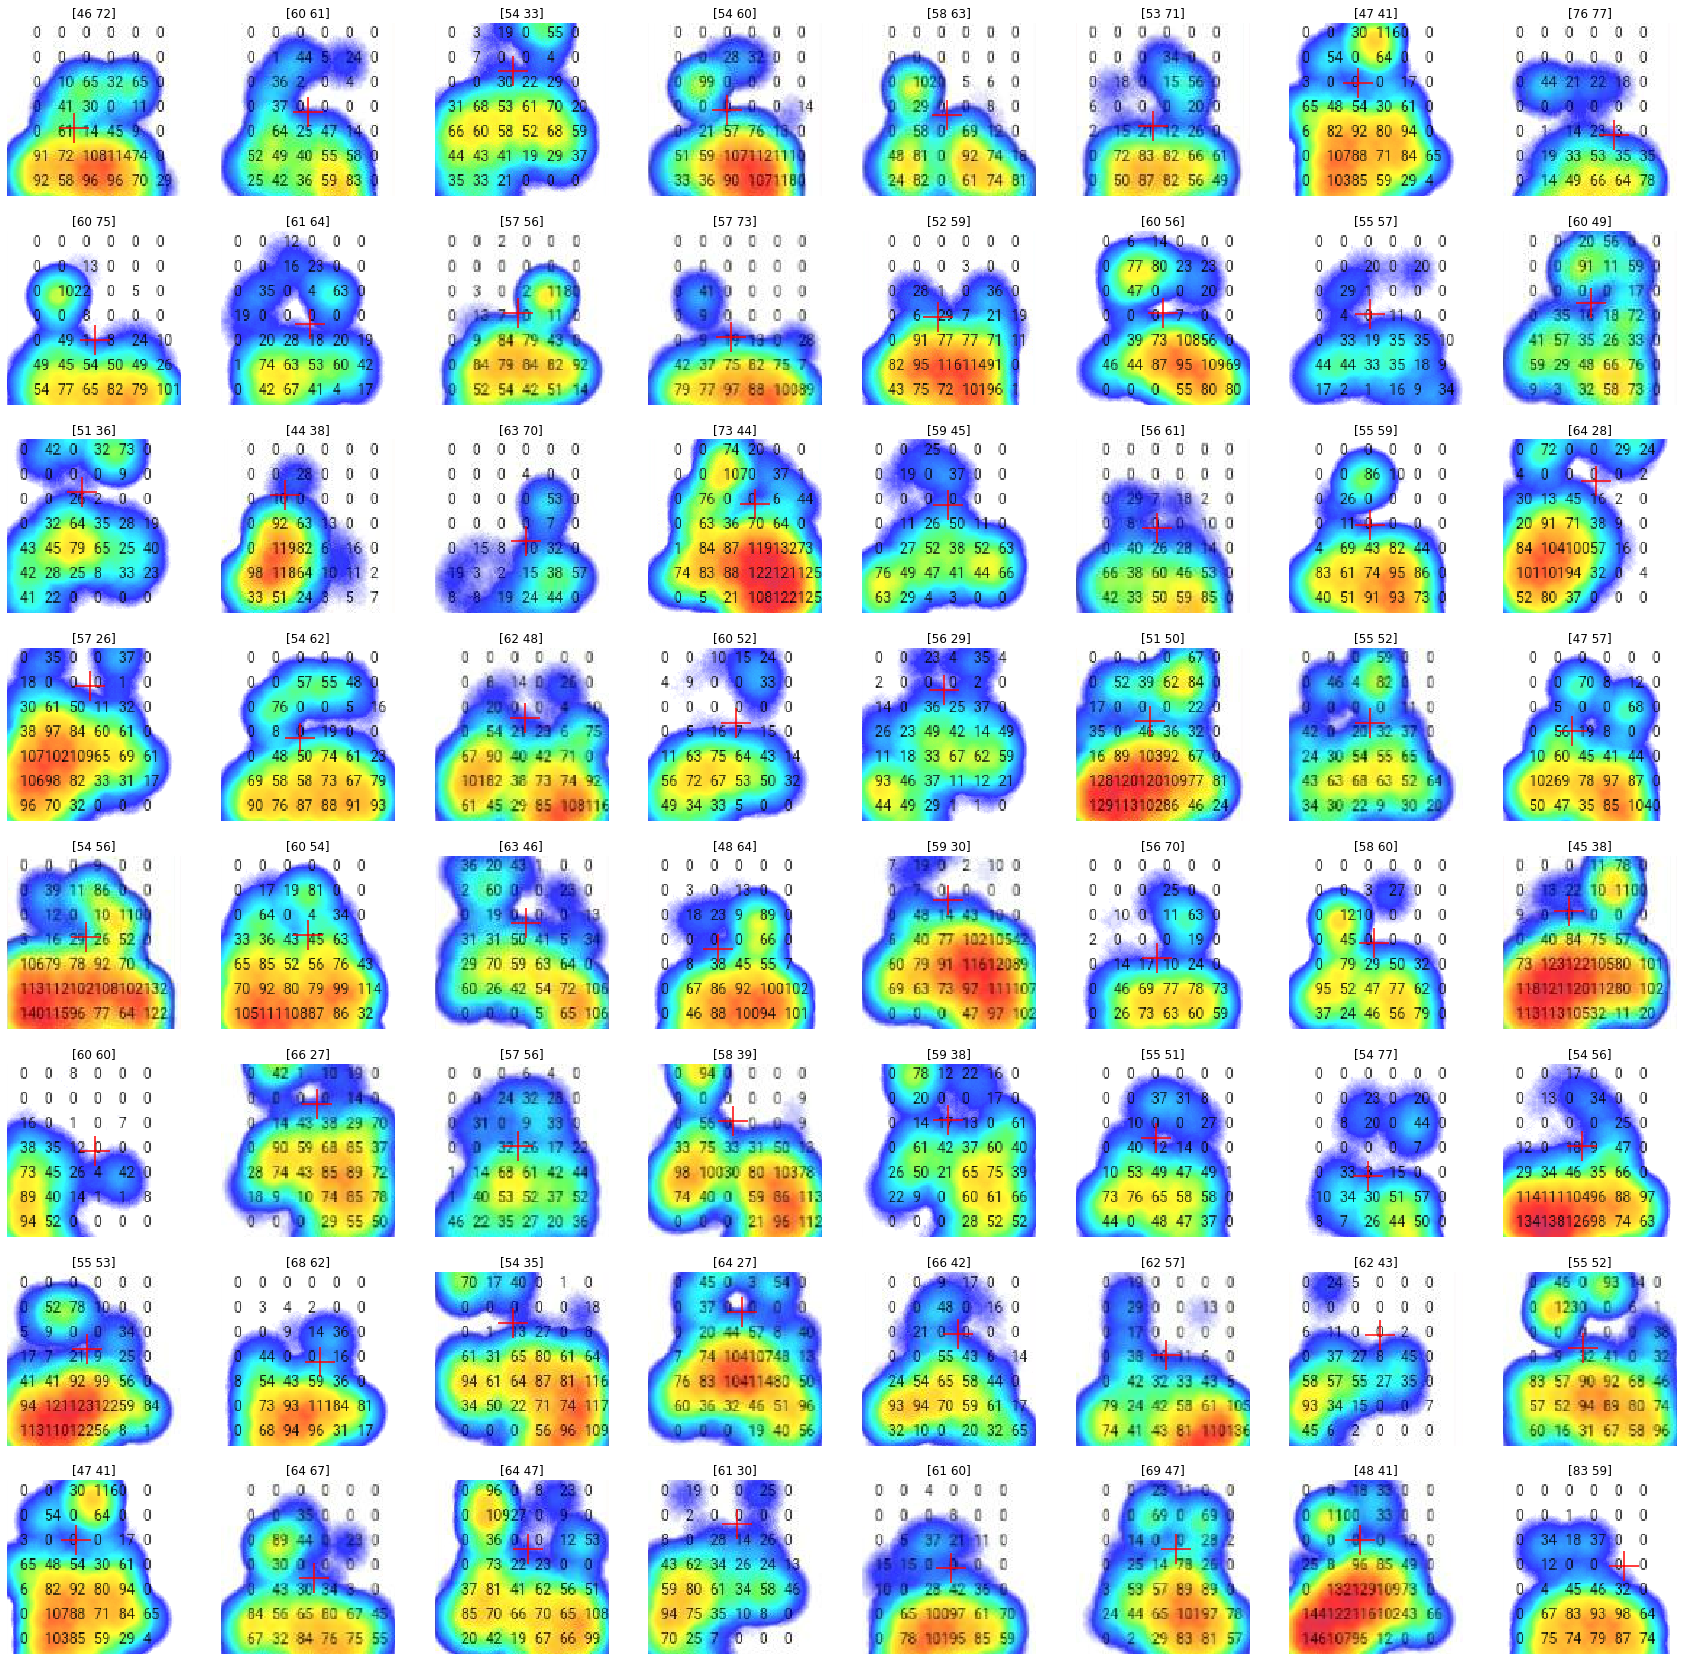

In [96]:
%%time

# for albu keypoint

# for return aug_img, aug_xy 


image_batch, label_batch = next(it_valid_ds_pre_toe_s)

fig = plt.figure(figsize=(30, 30))
print('batch * multi:', len(label_batch), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
for i in range(64):
    ax = plt.subplot(8, 8, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(label_batch[i].numpy())
    plt.axis("off")

    plt.plot(label_batch[i].numpy()[0], label_batch[i].numpy()[1], 'r+', markersize=30, mew=1.5)

    print(f'Check lables: {label_batch[i]}')
        

In [97]:
# # for return aug_img, aug_xy 

# %%time

# #heel redo

# plt.figure(figsize=(8, 8))
# for images, labels in train_ds_pre_heel_s.take(1):
#     print('batch * multi:', len(labels), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
#     for i in range(16):
#         ax = plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(labels[i].numpy())
#         plt.axis("off")
        
#         for (x,y) in labels[i]:
#             plt.plot(int(x), int(y), 'r+', markersize=13, mew=2.5)
#             print(f'Check labels xy out: {x}:{y}') #[[56 34]]?

In [81]:
# %%time

# # plot_number_of_sample = MULTI_BATCH_SIZE
# # col_size = row_size = int(np.sqrt(MULTI_BATCH_SIZE))
# # # row_size = np.sqrt(MULTI_BATCH_SIZE)
# # print(col_size)

# plt.figure(figsize=(8, 8))
# for images, labels in train_ds_pre_heel_s.take(1):
#     print('batch * multi:', len(labels), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
#     for i in range(16):
#         ax = plt.subplot(4, 4, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title([labels[i].numpy()])
#         plt.axis("off")
        
#         plt.plot(labels[i].numpy()[0], labels[i].numpy()[1], 'r+', markersize=13, mew=2.5)

In [82]:
labels[1]

NameError: name 'labels' is not defined

In [ ]:
%%time

# plot_number_of_sample = MULTI_BATCH_SIZE
# col_size = row_size = int(np.sqrt(MULTI_BATCH_SIZE))
# # row_size = np.sqrt(MULTI_BATCH_SIZE)
# print(col_size)

fig = plt.figure(figsize=(8, 8))
for images, labels in valid_ds_pre_toe_s.take(1):
    print('batch * multi:', len(labels), ', MULTI_BATCH_SIZE=', MULTI_BATCH_SIZE)
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title([labels[i].numpy()])
        plt.axis("off")
        
        plt.plot(labels[i].numpy()[0], labels[i].numpy()[1], 'r+', markersize=13, mew=2.5)

In [ ]:
%%time
def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
#     image = image.numpy()
    label = label.numpy()

    fig = plt.figure(figsize=(11, 11))
    for i in range(20):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i].numpy().astype("uint8"))
        ax.set_title(f"Label: {label[i]}", color="r")

view_image(train_ds_pre_toe_s)